In [1]:
# import required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import datasets
from sklearn import svm
from tensorflow.python.framework import ops
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib
ops.reset_default_graph()

# Se cargan los datos

In [2]:
#sess = tf.Session()# Training loop
Xdf_raw = pd.read_csv("../IndoorFingerprint.csv").drop("Y", axis=1)
Ydf_raw = pd.read_csv("../IndoorFingerprint.csv").drop("X", axis=1)

# Se escalan los datos

In [3]:
# Normalizacion de los datos
atribute_numbers = Xdf_raw.shape[1]-1

# Valores para el dataset que predice X
'''Xtrx, Xtex, ytrx, ytex = train_test_split(
Xdf_raw.iloc[:, 1:], Xdf_raw["X"], test_size=0.2, random_state=0)
train_size = len(Xtrx)
test_size = len(Xtex)

# Valores para el dataset que predice Y
Xtry, Xtey, ytry, ytey = train_test_split(
Ydf_raw.iloc[:, 1:], Ydf_raw["Y"], test_size=0.2, random_state=0)'''

# Se normalizan los datos para ambos

scaler = preprocessing.StandardScaler()
Xtrx = scaler.fit_transform(Xdf_raw.iloc[:, 1:])
print(Xtrx[0])
ytrx = Xdf_raw["X"]
#Xtex = scaler.transform(Xtex)

scaler = preprocessing.StandardScaler()
Xtry = scaler.fit_transform(Ydf_raw.iloc[:, 1:])
ytry = Ydf_raw["Y"]
#Xtey = scaler.transform(Xtey)

[ 0.08430494 -0.18002194  0.73871764 -0.14216012 -0.19295818 -1.66789412
 -1.22099891 -0.71566993]


# PCA(opcional)

In [4]:
'''from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components=2)
Xred_pca = sklearn_pca.fit_transform(X_std)'''

'from sklearn.decomposition import PCA\nsklearn_pca = PCA(n_components=2)\nXred_pca = sklearn_pca.fit_transform(X_std)'

In [5]:
class_number_x = ytrx.unique().size
class_number_y = ytry.unique().size

ytrx_dummy = pd.get_dummies(ytrx)
#ytex_dummy = pd.get_dummies(ytex)

ytry_dummy = pd.get_dummies(ytry)
#ytey_dummy = pd.get_dummies(ytey)

# Se convierten valores a Tensores X

Xtrx = np.array(Xtrx,dtype='float32')
#Xtex = np.array(Xtex,dtype='float32')
ytrx_dummy = np.array(ytrx_dummy,dtype='int32').T
#ytex_dummy = np.array(ytex_dummy,dtype='int32').T
ytrx_dummy[ytrx_dummy == 0] = -1
#ytex_dummy[ytex_dummy == 0] = -1

# Se convierten valores a Tensores Y

Xtry = np.array(Xtry,dtype='float32')
#Xtey = np.array(Xtey,dtype='float32')
ytry_dummy = np.array(ytry_dummy,dtype='int32').T
#ytey_dummy = np.array(ytey_dummy,dtype='int32').T
ytry_dummy[ytry_dummy == 0] = -1
#ytey_dummy[ytey_dummy == 0] = -1

ytrx_cat = pd.Series(ytrx, dtype="category")
ytrx = np.array(ytrx_cat.cat.codes,dtype='int32')
#ytex_cat = pd.Series(ytex, dtype="category")
#ytex = np.array(ytex_cat.cat.codes,dtype='int32')

In [6]:
batch_size = 32

In [7]:
# Initialize placeholders
x_data = tf.placeholder(shape=[None, atribute_numbers], dtype=tf.float32)
y_target_x = tf.placeholder(shape=[class_number_x, None], dtype=tf.float32)
y_target_y = tf.placeholder(shape=[class_number_y, None], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, atribute_numbers], dtype=tf.float32, name="I")
#prediction_test = tf.placeholder(shape=[None], dtype=tf.int64)

# Create variables for svm X
bx = tf.Variable(tf.random_normal(shape=[class_number_x,batch_size]))

# Create variables for svm Y
by = tf.Variable(tf.random_normal(shape=[class_number_y,batch_size]))

In [8]:
# Gaussian (RBF) kernel
gamma = tf.constant(-4.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

In [9]:
# Declare function to do reshape/batch multiplication
def reshape_matmul(mat,class_numberP):
    v1 = tf.expand_dims(mat, 1)
    v2 = tf.reshape(v1, [class_numberP, batch_size, 1])
    return(tf.matmul(v2, v1))

In [10]:
# Compute SVM Model X
first_term_x = tf.reduce_sum(bx)
bx_vec_cross = tf.matmul(tf.transpose(bx), bx)
y_target_cross_x = reshape_matmul(y_target_x,class_number_x)

second_term_x = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(bx_vec_cross, y_target_cross_x)),[1,2])
loss_x = tf.reduce_sum(tf.negative(tf.subtract(first_term_x, second_term_x)))

# Compute SVM Model Y
first_term_y = tf.reduce_sum(by)
by_vec_cross = tf.matmul(tf.transpose(by), by)
y_target_cross_y = reshape_matmul(y_target_y,class_number_y)

second_term_y = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(by_vec_cross, y_target_cross_y)),[1,2])
loss_y = tf.reduce_sum(tf.negative(tf.subtract(first_term_y, second_term_y)))

In [11]:
# Gaussian (RBF) prediction kernel
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

# Para X
prediction_output_x = tf.matmul(tf.multiply(y_target_x,bx), pred_kernel)
prediction_x = tf.arg_max(prediction_output_x-tf.expand_dims(tf.reduce_mean(prediction_output_x,1), 1), 0)
#prediction_x = tf.arg_max(prediction_output_x, 0)
accuracy_x = tf.reduce_mean(tf.cast(tf.equal(prediction_x, tf.argmax(y_target_x,0)), tf.float32))
#accuracy_test_x = tf.reduce_mean(tf.cast(tf.equal(prediction_test, tf.argmax(y_target_x,0)), tf.float32))

# Para Y
prediction_output_y = tf.matmul(tf.multiply(y_target_y,by), pred_kernel)
prediction_y = tf.arg_max(prediction_output_y-tf.expand_dims(tf.reduce_mean(prediction_output_y,1), 1), 0)
#prediction_y = tf.arg_max(prediction_output_y, 0)
accuracy_y = tf.reduce_mean(tf.cast(tf.equal(prediction_y, tf.argmax(y_target_y,0)), tf.float32))
#accuracy_test_y = tf.reduce_mean(tf.cast(tf.equal(prediction_test, tf.argmax(y_target_y,0)), tf.float32))

In [12]:
# Declare optimizer
my_opt_x = tf.train.GradientDescentOptimizer(0.001)
train_step_x = my_opt_x.minimize(loss_x)

# Y
my_opt_y = tf.train.GradientDescentOptimizer(0.001)
train_step_y = my_opt_y.minimize(loss_y)

# Se crea la variable a guardar 
saver = tf.train.Saver()
init_op = tf.global_variables_initializer()

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[1]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[:,excerpt]

Step #25
Loss = -963384.0
Step #50
Loss = -3.56857e+09
[7 0]
Output ejemplo [7 0]


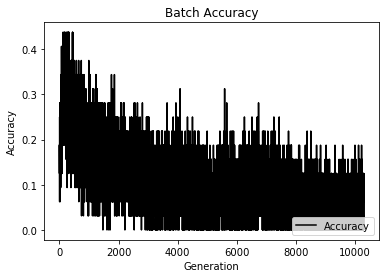

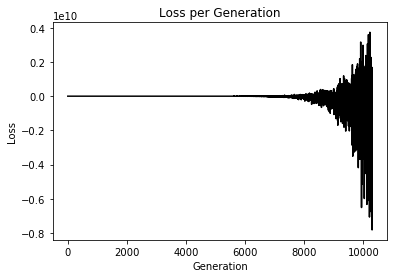

In [13]:
# Training loop
loss_vec_x = []
batch_accuracy_x = []

loss_vec_y = []
batch_accuracy_y = []
with tf.Session() as sess:
    sess.run(init_op)
    for i in range(50):
        for batch in iterate_minibatches(Xtrx, ytrx_dummy, batch_size, shuffle=True):
            rand_xx, rand_yx = batch
            sess.run(train_step_x, feed_dict={x_data: rand_xx, y_target_x: rand_yx})

            temp_loss_x = sess.run(loss_x, feed_dict={x_data: rand_xx, y_target_x: rand_yx})
            loss_vec_x.append(temp_loss_x)

            acc_temp_x = sess.run(accuracy_x, feed_dict={x_data: rand_xx,
                                                     y_target_x: rand_yx,
                                                     prediction_grid:rand_xx})
            batch_accuracy_x.append(acc_temp_x)
            
        for batch in iterate_minibatches(Xtry, ytry_dummy, batch_size, shuffle=True):
            rand_xy, rand_yy = batch
            sess.run(train_step_y, feed_dict={x_data: rand_xy, y_target_y: rand_yy})

            temp_loss_y = sess.run(loss_y, feed_dict={x_data: rand_xy, y_target_y: rand_yy})
            loss_vec_y.append(temp_loss_y)

            acc_temp_y = sess.run(accuracy_y, feed_dict={x_data: rand_xy,
                                                     y_target_y: rand_yy,
                                                     prediction_grid:rand_xy})
            batch_accuracy_y.append(acc_temp_y)

        if (i+1)%25==0:
            print('Step #' + str(i+1))
            print('Loss = ' + str(temp_loss_x))
            
    # Creada solo para android
    rand_xAx = tf.constant(rand_xx, dtype="float32")
    rand_yAx = tf.constant(rand_yx, dtype="float32")
    
    rand_xAy = tf.constant(rand_xy, dtype="float32")
    rand_yAy = tf.constant(rand_yy, dtype="float32")

    mientras = np.array([[0.08430494, -0.18002194,  0.73871764, -0.14216012, -0.19295818, -1.66789412,
 -1.22099891, -0.71566993]],dtype="float32")

    # Gaussian (RBF) prediction kernel X
    rAAx = tf.reshape(tf.reduce_sum(tf.square(rand_xAx), 1),[-1,1])
    rBAx = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
    pred_sq_distAx = tf.add(tf.subtract(rAAx, tf.multiply(2., tf.matmul(rand_xAx, tf.transpose(prediction_grid)))), tf.transpose(rBAx))
    pred_kernelAx = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_distAx)))

    prediction_outputAx = tf.matmul(tf.multiply(rand_yAx,bx), pred_kernelAx)
    predictionAx = tf.arg_max(prediction_outputAx, 0)
    outputNodex = tf.cast(predictionAx, tf.int32)
    
    # Gaussian (RBF) prediction kernel Y
    rAAy = tf.reshape(tf.reduce_sum(tf.square(rand_xAy), 1),[-1,1])
    rBAy = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
    pred_sq_distAy = tf.add(tf.subtract(rAAy, tf.multiply(2., tf.matmul(rand_xAy, tf.transpose(prediction_grid)))), tf.transpose(rBAy))
    pred_kernelAy = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_distAy)))

    prediction_outputAy = tf.matmul(tf.multiply(rand_yAy,by), pred_kernelAy)
    predictionAy = tf.arg_max(prediction_outputAy, 0)
    outputNodey = tf.cast(predictionAy, tf.int32)
    
    output = tf.concat([outputNodex,outputNodey],0, name = "O")
    
    print(sess.run(output, feed_dict={prediction_grid: mientras}))
    
    '''predictions_x = sess.run(prediction_x, feed_dict={x_data: rand_xx,
                                       y_target_x: rand_yx,
                                       prediction_grid: Xtex})
    
    predictions_y = sess.run(prediction_y, feed_dict={x_data: rand_xy,
                                       y_target_y: rand_yy,
                                       prediction_grid: Xtey})
    
    print("Acc Test Set X: ", sess.run(accuracy_test_x, feed_dict={y_target_x: ytex_dummy,
                                      prediction_test: predictions_x}))
    
    print("Acc Test Set Y: ", sess.run(accuracy_test_y, feed_dict={y_target_y: ytey_dummy,
                                       prediction_test: predictions_y}))'''
    
    print("Output ejemplo", sess.run(output, feed_dict={prediction_grid: mientras}))
    
    tf.train.write_graph(sess.graph_def, '.', 'svmX.pbtxt')
    saver.save(sess, './svmX.ckpt')
    
    
# Plot batch accuracy
plt.plot(batch_accuracy_x, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(loss_vec_x, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [14]:
MODEL_NAME = 'svmX'

# Freeze the graph

input_graph_path = MODEL_NAME+'.pbtxt'
checkpoint_path = './'+MODEL_NAME+'.ckpt'
input_saver_def_path = ""
input_binary = False
output_node_names = "O"
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'
output_optimized_graph_name = 'optimized_'+MODEL_NAME+'.pb'
clear_devices = True


freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
                          input_binary, checkpoint_path, output_node_names,
                          restore_op_name, filename_tensor_name,
                          output_frozen_graph_name, clear_devices, "")

INFO:tensorflow:Restoring parameters from ./svmX.ckpt
INFO:tensorflow:Froze 2 variables.
Converted 2 variables to const ops.
90 ops in the final graph.


In [15]:
# Optimizacion

input_graph_def = tf.GraphDef()
with tf.gfile.Open(output_frozen_graph_name, "rb") as f:
    data = f.read()
    input_graph_def.ParseFromString(data)

output_graph_def = optimize_for_inference_lib.optimize_for_inference(
        input_graph_def,
        ["I"], # an array of the input node(s)
        ["O"], # an array of output nodes
        tf.float32.as_datatype_enum)

# Save the optimized graph

f = tf.gfile.FastGFile(output_optimized_graph_name, "w")
f.write(output_graph_def.SerializeToString())